In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn import metrics
import matplotlib.pyplot as plt
from keras.models import Sequential
from pandas_datareader import data as pdr
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split

In [2]:
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir('/content/drive/MyDrive/GDSC AI Stock')

In [5]:
## Yahoo Finance for TSLA and VIX

yf.pdr_override()
df = pdr.get_data_yahoo("TSLA", start = "2015-01-01", end = "2023-12-31").reset_index()
vix = pdr.get_data_yahoo("^VIX", start = "2015-01-01", end = "2023-12-31").reset_index()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
fin = pd.read_csv('./Financial Statement.csv')

df['Date'] = pd.to_datetime(df['Date'])
vix['Date'] = pd.to_datetime(vix['Date'])
fin['Date'] = pd.to_datetime(fin['Date'])

df.drop(columns = ['Adj Close'], inplace = True)
vix = vix[['Date', 'Close']]
fin = fin[['Date', 'Gross Margin (YoY%)', 'Operating Margin (YoY%)', 'Quick Ratio (YoY%)', 'EPS Growth (USD)']]
df['Delta'] = round(df['Close'].pct_change()*100, 4)
df.dropna(inplace = True)

In [7]:
df = pd.merge(left = df, right = vix, left_on = 'Date', right_on = 'Date', suffixes = ('_TSLA', '_VIX'), how = 'left')
df = pd.merge(left = df, right = fin, left_on = 'Date', right_on = 'Date', how = 'left')
df.set_index('Date', inplace = True)

In [8]:
def custom_ffill(series):

    previous_value = None
    day = 0

    for i, value in series.items():

        if pd.isna(value):
            day += 1
            if previous_value is not None:

                series[i] = previous_value / 2
                previous_value = previous_value / 2

                # if abs(previous_value) <= float(1e-4):
                if day > 14:
                    previous_value = 0
        else:
            previous_value = value
            day = 0

    return series

for c in df:
    df[c] = custom_ffill(df[c])

df.dropna(inplace = True)
df.reset_index(inplace = True)

In [9]:
df['Open_Close'] = 0.0
df['High_Low'] = 0.0

for i in range(len(df)):
    df['Open_Close'][i] = (df['Open'][i] - df['Close_TSLA'][i]) * 100 / df['Open'][i]
    df['High_Low'][i] = (df['High'][i] - df['Low'][i]) * 100 / df['Low'][i]

In [10]:
df['Target'] = df['Close_TSLA'].shift(-1)
df.dropna(inplace = True)

features = df[["Close_TSLA", "Volume", "Close_VIX", "Gross Margin (YoY%)", "Operating Margin (YoY%)", "Quick Ratio (YoY%)", "EPS Growth (USD)", "Open_Close", "High_Low"]]
target = df['Target']

In [17]:
features

,Close_TSLA,Volume,Close_VIX,Gross Margin (YoY%),Operating Margin (YoY%),Quick Ratio (YoY%),EPS Growth (USD),Open_Close,High_Low
0,12.584667,75399000,15.29,27.670000,-10.90000,0.80,-0.050000,2.459566,2.839544
1,12.506000,56919000,15.11,13.835000,-5.45000,0.40,-0.025000,0.588238,3.359315
2,12.733333,75156000,14.67,6.917500,-2.72500,0.20,-0.012500,-0.404766,1.699997
3,13.540000,186837000,14.74,3.458750,-1.36250,0.10,-0.006250,-2.575759,5.189874
4,13.550000,65218500,14.78,1.729375,-0.68125,0.05,-0.003125,-0.365416,1.948892
...,...,...,...,...,...,...,...,...,...
2198,254.500000,109594200,13.65,0.000000,0.00000,0.00,0.000000,-1.032158,2.514585
2199,252.539993,93249800,13.03,0.000000,0.00000,0.00,0.000000,1.643565,2.725069
2200,256.609985,86892400,12.99,0.000000,0.00000,0.00,0.000000,-0.833031,2.000711
2201,261.440002,106494400,12.43,0.000000,0.00000,0.00,0.000000,-1.196050,2.260022


In [11]:
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))

num_train = int(len(features_scaled) * 0.9)

x_train = features_scaled[:num_train]
x_test = features_scaled[num_train:]

y_train = target_scaled[:num_train]
y_test = target_scaled[num_train:]

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

x_train.shape, x_test.shape

((1982, 1, 9), (221, 1, 9))

In [19]:
model = Sequential()
model.add(LSTM(128, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

history = model.fit(x_train, y_train, batch_size = 8, epochs = 10)

Epoch 1/10
248/248 [==============================] - 5s 5ms/step - loss: 0.0138
Epoch 2/10
248/248 [==============================] - 1s 5ms/step - loss: 3.1804e-04
Epoch 3/10
248/248 [==============================] - 1s 5ms/step - loss: 3.2006e-04
Epoch 4/10
248/248 [==============================] - 2s 7ms/step - loss: 3.4738e-04
Epoch 5/10
248/248 [==============================] - 2s 6ms/step - loss: 3.5000e-04
Epoch 6/10
248/248 [==============================] - 1s 5ms/step - loss: 3.6618e-04
Epoch 7/10
248/248 [==============================] - 1s 5ms/step - loss: 3.1849e-04
Epoch 8/10
248/248 [==============================] - 1s 5ms/step - loss: 3.0493e-04
Epoch 9/10
248/248 [==============================] - 1s 5ms/step - loss: 2.9926e-04
Epoch 10/10
248/248 [==============================] - 1s 5ms/step - loss: 3.1509e-04


In [20]:
loss = model.evaluate(x_test, y_test)
print(f'Mean Squared Error on Test Data: {round(loss, 4)}')

7/7 [==============================] - 1s 4ms/step - loss: 8.8617e-04
Mean Squared Error on Test Data: 0.0009


In [21]:
x_new = np.reshape(features_scaled[-1], (1, 1, features_scaled.shape[1]))
predicted_scaled = model.predict(x_new)
predicted = scaler.inverse_transform(predicted_scaled)
print(f'Predicted Close_TSLA for the next day: {predicted[0][0]}')

1/1 [==============================] - 1s 613ms/step
Predicted Close_TSLA for the next day: 263.9635009765625


In [22]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

7/7 [==============================] - 0s 3ms/step


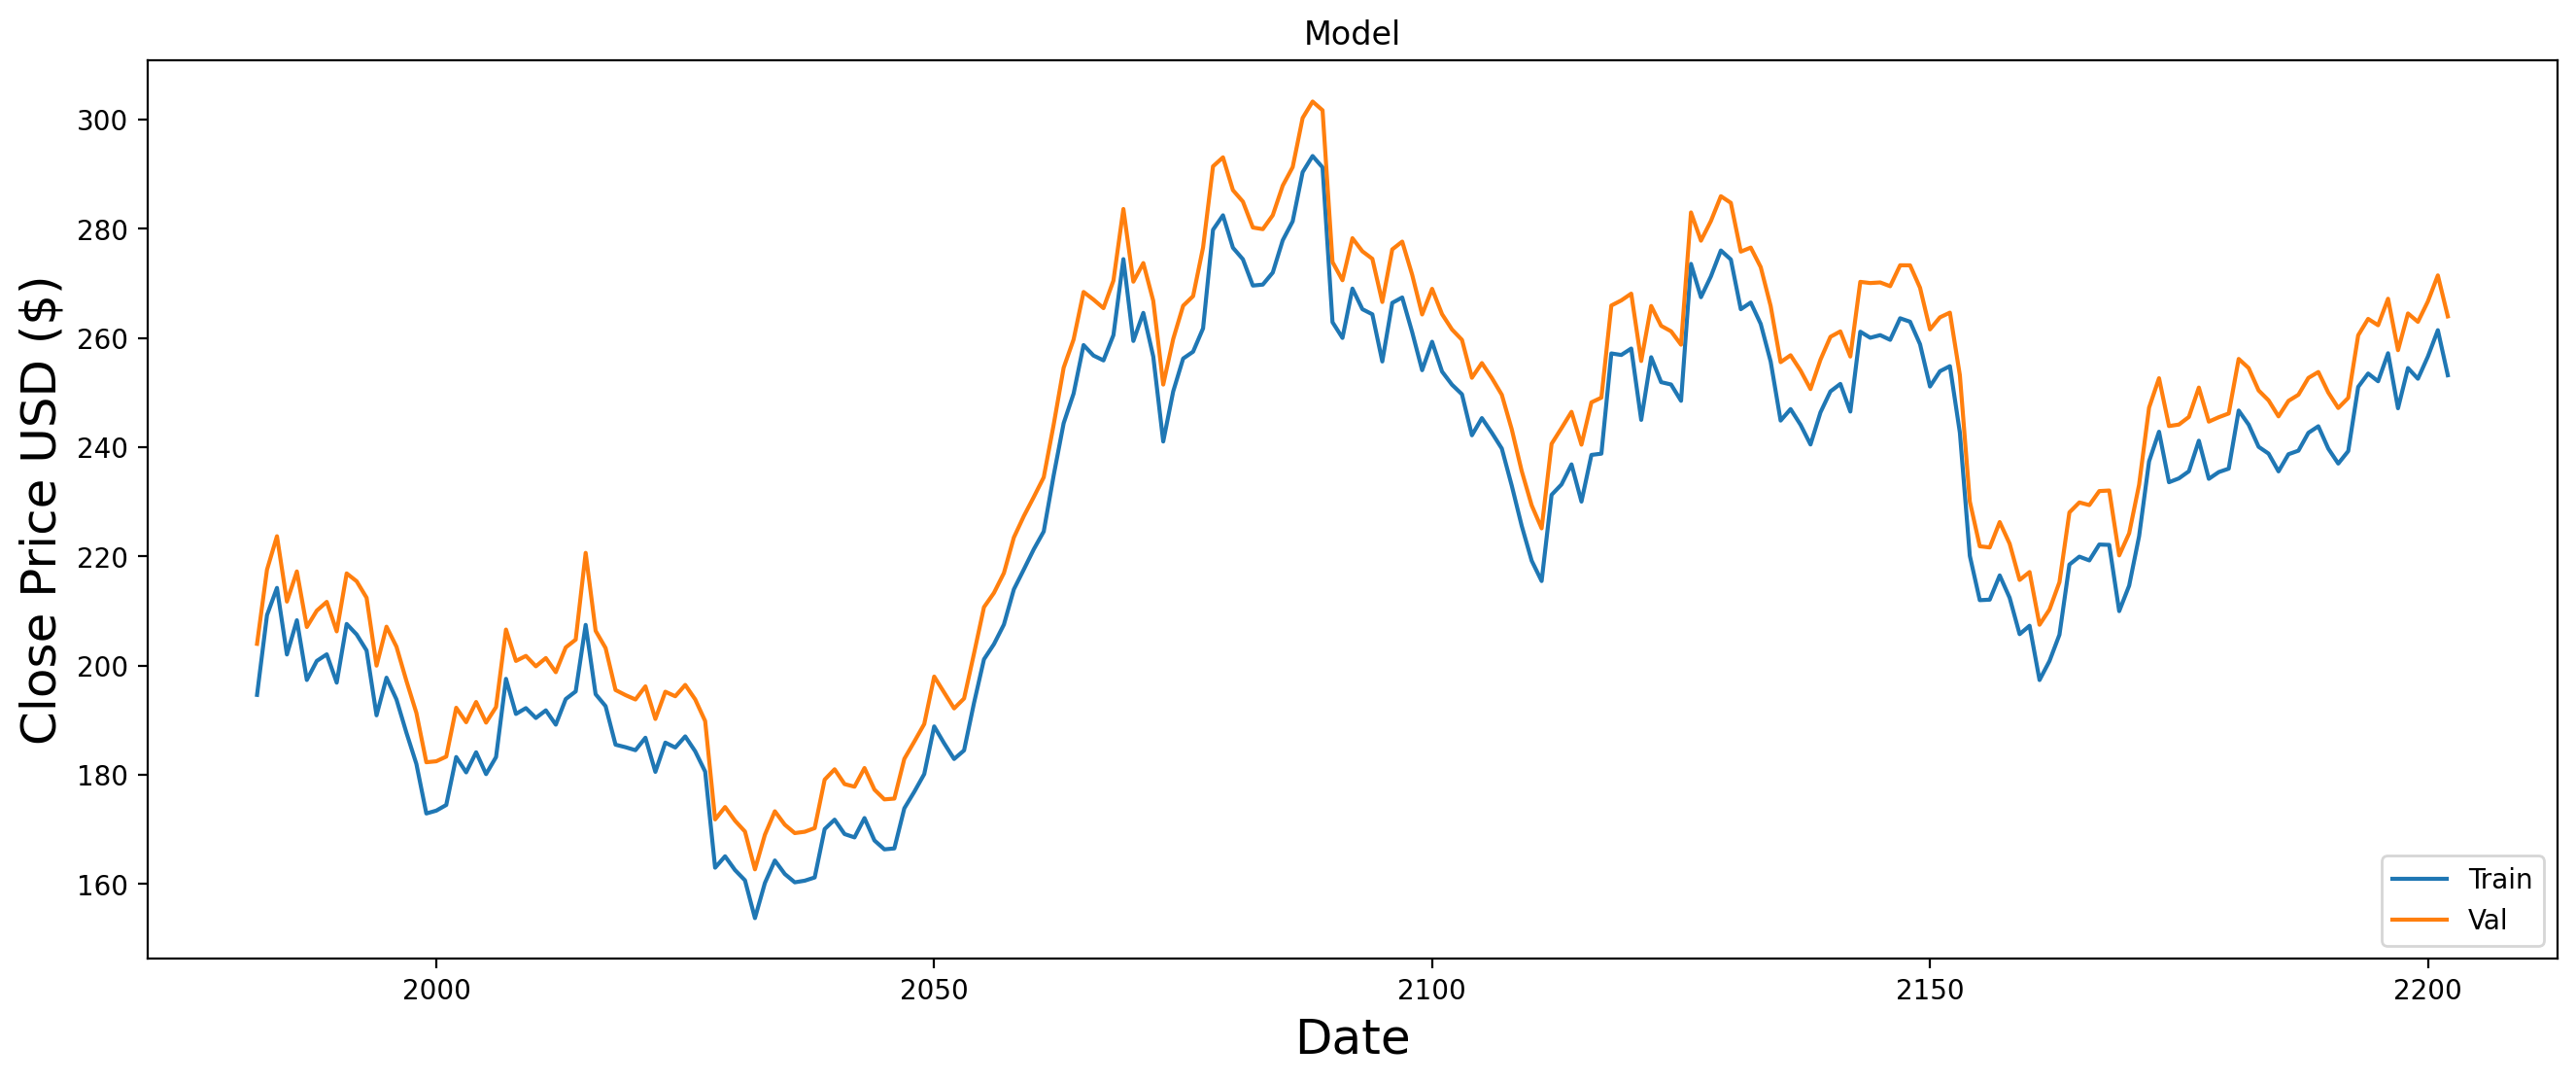

In [23]:
train = df[['Close_TSLA']][:num_train]
valid = df[['Close_TSLA']][num_train:]
valid['Predictions'] = predictions

plt.figure(figsize = (16,6))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
# plt.plot(train['Close_TSLA'])
plt.plot(valid[['Close_TSLA', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right')
plt.show()